# Dealing with multiple half-sib families

Tom Ellis, March 2018

In the previous sections on [genotype arrays](https://github.com/ellisztamas/faps/blob/master/docs/02%20Genotype%20data.ipynb), [paternity arrays](https://github.com/ellisztamas/faps/blob/master/docs/03%20Paternity%20arrays.ipynb) and [sibship clustering](https://github.com/ellisztamas/faps/blob/master/docs/04%20Sibship%20clustering.ipynb) we considered only a single half-sibling array. In most real-world situations, you would probably have multiple half-sibling arrays from multiple mothers.

FAPS assumes that these families are independent, which seems a reasonable assumption for most application, so dealing with multiple families boils down to performing the same operation on these families through a loop. This guide outlines some tricks to automate this.

This notebook will examine how to:

1. Divide a dataset into multiple families
2. Perform sibship clustering on those families
3. Extract information from objects for multiple families

To illustrate this we will use data from wild-pollinated seed capsules of the snapdragon *Antirrhinum majus*. Each capsule represents a single maternal family, which may contain mixtures of full- and half-siblings. Each maternal family can be treated as independent.

These are the raw data described in Ellis *et al.* (2018), and are available from the [IST Austria data repository](https://datarep.app.ist.ac.at/id/eprint/95) (DOI:10.15479/AT:ISTA:95). For the analysis presented in that paper we did extensive data cleaning and checking, which is given as a [case study](https://github.com/ellisztamas/faps/blob/master/docs/08%20Data%20cleaning%20in%20A.%20majus.ipynb) later in this guide. Here, we will skip this process, since it primarily concerns accuracy of results.

##  Divide a dataset into families

There are two ways to divide data into families: by splitting up a `genotypeArray` into families, and making a `paternityArray` for each, or create a single `paternityArray` and split up that.

### Import the data

Frequently offspring have been genotyped from multiple half-sibling arrays, and it is convenient to store these data together in a single file on disk. However, it (usually) only makes sense to look for sibling relationships *within* known half-sib families, so we need to split those data up into half-sibling famililes.

First, import the required packages and data for the sample of candidate fathers and the progeny.

In [1]:
import numpy as np
from faps import *
import matplotlib.pyplot as plt
%pylab inline

adults  = read_genotypes('../manuscript_faps/data_files/parents_SNPs_2012.csv', genotype_col=1)
progeny = read_genotypes('../manuscript_faps/data_files/offspring_SNPs_2012.csv', genotype_col=2, mothers_col=1)


Populating the interactive namespace from numpy and matplotlib


We need to remove four families whose mother is not included in the sample of adults.

In [2]:
ix = [m in adults.names for m in progeny.mothers]
progeny = progeny.subset(ix)

We also need to define an array of genotypes for the mothers, population allele frequencies, and a genotyping error rate.

In [3]:
mothers = adults.subset(progeny.parent_index('m', adults.names))
allele_freqs = adults.allele_freqs() # population allele frequencies
mu= 0.0015

Pull out the numbers of adults and progeny in the dataset, as well as the number of maternal families.

In [4]:
print adults.size
print progeny.size
print len(np.unique(progeny.mothers))

2145
1392
59


Most maternal families are between 20 and 30, with some either side.

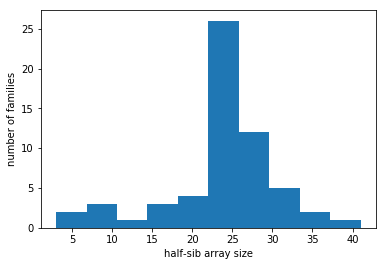

In [5]:
family_sizes = np.unique(progeny.mothers, return_counts=True)[1]
plt.hist(family_sizes)
plt.xlabel('half-sib array size')
plt.ylabel('number of families')
plt.show()

### Split up the `genotypeArray`

In the data import we specified that the ID of the mother of each offspring individual was given in column 2 of the data file (i.e. column 1 for Python, which starts counting from zero). Currently this information is contained in `progeny.mothers`.

To separate a `genotypeArray` into separate families you can use `split`, and the vector of maternal names. This returns a **list** of `genotypeArray` objects for each maternal family.

In [6]:
progeny2 = progeny.split(progeny.mothers)
mothers2 = mothers.split(progeny.mothers)

print len(progeny2)
print len(mothers2)

59
59


You can then pass the lists of `genotypeArray` objects to `paternity_array` directly, just as if they were single objects. `paternity_array` detects that these are lists, and returns a list of `paternityArray` objects. The `%%time` magic operator is used to time  how long it takes to run the cell.

In [7]:
%%time
patlik = paternity_array(progeny2, mothers2, adults, allele_freqs, mu)
print len(patlik)

59
CPU times: user 26.4 s, sys: 562 ms, total: 27 s
Wall time: 27 s


### Split up a paternity array

The alternative way to do this is to pass the entire arrays for progeny and mothers to 
`paternity_array`. A word of caution is needed here, because `paternity_array` is quite memory hungry, and for large datasets there is a very real chance you could exhaust the RAM on your computer and the machine will grind to a halt.

In [8]:
%%time
patlik2 = paternity_array(progeny, mothers, adults, allele_freqs, mu)

CPU times: user 25.4 s, sys: 2.81 s, total: 28.2 s
Wall time: 28.3 s


There doesn't seem to be any difference in speed the two methods, although in other cases I have found that creating a single `paternityArray` is slower. Your mileage may vary.

We split up the `paternity_array` in the same way as a `genotype_array`. It returns a list of `paternityArray` objects.

In [11]:
patlik3 = patlik2.split(progeny.mothers)
len(patlik3)

59

We would hope that `patlik` and `patlik3` are identical lists of `paternityArray` objects. We can inspect some elements to check:

In [19]:
patlik[0].offspring

array(['L0057_745', 'L0057_746', 'L0057_747', 'L0057_748', 'L0057_749',
       'L0057_750', 'L0057_751', 'L0057_752', 'L0057_753', 'L0057_754',
       'L0057_755', 'L0057_756', 'L0057_846', 'L0057_847', 'L0057_848',
       'L0057_849', 'L0057_850', 'L0057_851', 'L0057_852', 'L0057_853',
       'L0057_854', 'L0057_855', 'L0057_856', 'L0057_857'], dtype='|S12')

In [21]:
patlik3[0].offspring

array(['L0057_745', 'L0057_746', 'L0057_747', 'L0057_748', 'L0057_749',
       'L0057_750', 'L0057_751', 'L0057_752', 'L0057_753', 'L0057_754',
       'L0057_755', 'L0057_756', 'L0057_846', 'L0057_847', 'L0057_848',
       'L0057_849', 'L0057_850', 'L0057_851', 'L0057_852', 'L0057_853',
       'L0057_854', 'L0057_855', 'L0057_856', 'L0057_857'], dtype='|S12')

### Clustering for multiple families

`sibship_clustering` is also able to detect when a list of `paternityArray` objects is being passed, and treat each independently.

In [14]:
%%time
sc = sibship_clustering(patlik3)
print len(sc)

CPU times: user 15.4 s, sys: 11.6 ms, total: 15.4 s
Wall time: 15.4 s


You can index any single family to extract information about it in the same way as was explained in the section on [sibship clustering](http://localhost:8888/notebooks/docs/04%20Sibship%20clustering.ipynb). For example, the posterior distribution of full-sibship sizes for the first maternal family.

In [33]:
sc[0].family_size()

array([7.88207117e-001, 1.65810880e-001, 4.59820025e-002, 7.91328405e-056,
       4.73053622e-047, 0.00000000e+000, 7.07775904e-073, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 3.79961796e-089, 1.76711039e-102,
       0.00000000e+000, 0.00000000e+000, 1.24671469e-146, 2.61628434e-157,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       6.23849505e-234, 0.00000000e+000, 3.46413259e-271, 1.32932864e-291])

To extract information about each `sibshipCluster` object it is straightforward to set up a list comprehension. For example, this cell pulls out the number of partition structures for each maternal family.

In [27]:
[x.npartitions for x in sc]

array([24, 27, 26,  3, 25, 41, 25, 19, 24, 10, 22, 26, 33, 37, 22, 25, 11,
       21, 25, 27, 24, 31, 33, 20, 33, 25, 33, 26, 23, 24, 24, 26, 23, 16,
       23, 25, 27, 10, 25, 26, 26,  6, 16, 24, 23, 24, 22, 25, 20, 36, 24,
       26, 28, 18, 22, 26, 24,  9, 23])

Of course you can pull out attributes from lists of `genotypeArray` and `paternityArray` objects using list comprehensions as well. For example, this cell retieves the name of the mother for the first maternal family:

In [51]:
np.unique(progeny2[0].mothers)[0]

'L0057'

This list comprehension does this for all maternal families.

In [47]:
np.array([np.unique(x.mothers)[0] for x in progeny2])

array(['L0057', 'L0227', 'L1872', 'M0002', 'M0006', 'M0009', 'M0010',
       'M0012', 'M0014', 'M0018', 'M0022', 'M0025', 'M0028', 'M0034',
       'M0040', 'M0042', 'M0043', 'M0045', 'M0047', 'M0054', 'M0065',
       'M0069', 'M0078', 'M0130', 'M0138', 'M0202', 'M0209', 'M0210',
       'M0225', 'M0238', 'M0251', 'M0254', 'M0258', 'M0259', 'M0267',
       'M0283', 'M0285', 'M0310', 'M0323', 'M0329', 'M0333', 'M0339',
       'M0344', 'M0345', 'M0412', 'M0484', 'M0494', 'M0773', 'M0879',
       'M0884', 'M1000', 'M1333', 'M1335', 'M1454', 'M1460', 'M1463',
       'M1466', 'M1471', 'M1846'], dtype='|S5')